# XGBoost to predict discharge disability: SHAP

Use model as trained in previous notebook 010, and the SHAP values as calculated from that model in notebook 011.

Examine the consistency of the SHAP values for an individual patient across 5 k-folds.

### Plain English summary

Before look at feature selection, let's look at the consistency of the SHAP values for an individual for different data divisions (the 5-kfolds).

### Model and data
Model: XGBoost classifier (multiclass classification) [from notebook 010]\
Target feature: Discharge disability\
Input features: All the relevant features in SSNAP\
Kfold split: 5 kfold split\
[SHAP values from notebook 011]

### Aims
Is model performance (and patterns detected) dependent on the data divisions in the k-fold splits?

### Observations
Model performance (and patterns detected) are pretty consistent across the k-fold splits.
Confidence to do our analysis of SHAP values on a single kfold split. Removes the issue of accounting for different SHAP base values across the different kfold models.

#### Further work
Look at the difference of the SHAP for the patient population across the 5 k-fold splits (see notebook 013).

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb

(code orignially from 01a_xgb_kfold_all_features_accuracy_importance_shap.ipynb and 01_xgb_5fold_all_features_accuracy_importance_shap.ipynb)

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import auc

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

import pickle
import shap

from os.path import exists

import time
import datetime

shap.initjs()

Report the time duration to run notebook

In [2]:
start_time = time.time()

Choose number of kfolds (either =1 for the first kfold, or =5 for the full 5 kfold split)

In [3]:
n_kfold = 5

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [4]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_all_features_{n_kfold}fold'
    notebook: str = '012_'

paths = Paths()

Create output folders if needed

In [5]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

Some features need to be removed from the dataset (those that are duplicates). Define a function to do this.

In [6]:
def drop_columns(df, cols):
    """
    For the dataframe, remove the columns 'cols' if they are present
    
    Args:
        df [dataframe]: The feature values per patient
        cols [list]: The features to remove if present

    Return:
        df [dataframe]: The feature values per patient without specified columns
    """
    for col in cols:
        if col in df.columns: df.drop([col],axis=1,inplace=True)
    return(df)

Specify the columns to remove

In [7]:
cols_remove = ['id','stroke_team_id']

## Import data

Data has previously been split into 5 stratified k-fold splits. Read these in.

In [8]:
train_data_kfold, test_data_kfold = [], []

for k in range(n_kfold):
    # Read in training set, restrict to chosen features, rename titles, & store
    filename = os.path.join(paths.data_read_path, 
                            ('03_train_' + str(k) + '.csv'))
    train = pd.read_csv(filename)
#    train.rename(columns=dict_feature_name, inplace=True)
    train = drop_columns(train, cols_remove)
    train_data_kfold.append(train)

    filename = os.path.join(paths.data_read_path, 
                            ('03_test_' + str(k) + '.csv'))
    test = pd.read_csv(filename)
#    test.rename(columns=dict_feature_name, inplace=True)
    test = drop_columns(test, cols_remove)
    test_data_kfold.append(test)

Select the features for the model

In [9]:
selected_features = list(train_data_kfold[0])
selected_features.remove('discharge_disability')
n_features = len(selected_features)
selected_features.append('discharge_disability')

Limit dataset to selected features (in this case, we are keeping all the available features, the previous cell may specify otherwise for another purpose)

In [10]:
for k in range(n_kfold):
    train = train_data_kfold[k]
    train = train[selected_features]
    train_data_kfold[k] = train

    test = test_data_kfold[k]
    test = test[selected_features]
    test_data_kfold[k] = test

Store the output classes

In [11]:
class_names = train_data_kfold[0]['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)

Take copy of stroke team to use to create a histogram (before this feature is converted into a one hot encoded feature)

In [12]:
test_stroke_team_kfold = (
                 [test_data_kfold[k]["stroke_team"] for k in range(n_kfold)])

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [13]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [14]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [15]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features:
        for k in range(n_kfold):
            train_data_kfold[k] = (
                            convert_feature_to_one_hot(train_data_kfold[k], 
                                                       feature, prefix))
            test_data_kfold[k] = (
                            convert_feature_to_one_hot(test_data_kfold[k], 
                                                       feature, prefix))

Feature names with one hot encoding

In [16]:
feature_names_ohe = list(train_data_kfold[0])
feature_names_ohe.remove("discharge_disability")
n_features = len(feature_names_ohe)

In [17]:
print(f"There are {len(selected_features)} original features "
      f"(before one-hot encoding)")
print(f"There are {n_features} features (after one-hot encoding)")

There are 55 original features (before one-hot encoding)
There are 177 features (after one-hot encoding)


## Load XGBoost model

Load the model from notebook 010 that was trained on all features.

Create function to return X and y data for train and test sets

In [18]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    train (dataframe): dataframe containing training instances 
    test (dataframe): dataframe containing test instances
    target (string): column name of the targert feature (the column to separate from the two dataframes)
    """    

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

Create function to load xgboost model that was created in notebook 010

In [19]:
def load_xgboost_model(filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else return that user needs to run notebook 010 to create the model.

    Arg:
        filename [string]: where xgboost model is saved

    Return:
        model [model object]: xgboost classification model 
    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        print('Run notebook 010 first. Using the model that was trained there')
            
    return(model)

Create function to return SHAP values extension X and y data for train and test sets

In [20]:
def load_shap_extended(filename):
    """
    TreeExplainer is a fast and exact method to estimate SHAP values for tree 
    models and ensembles of trees. Using this we can calculate the SHAP values.

    Either load from pickle (if file exists), or calculate.

    model (xgboost object):
    k: kfold number
    X_train: training set (used as background data)
    X_test: test set (to calculate the SHAP values for)

    return the extended shap values (contains .values, .base, and .data)
        
    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load extended SHAP values
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Calculate SHAP values
        print('Run notebook 011 first. SHAP values were calculated there')
        
    return(shap_values_extended)

In [21]:
r_square_kfold = []
roc_auc_ovr_kfold = []
accuracy_kfold = []
error_within_one_kfold = []
feature_importance_kfold = []
y_probs_kfold = []
y_pred_kfold = []
model_kfold = []
shap_values_extended_kfold = []
shap_values_kfold = []

# Loop through k folds
for k in range(n_kfold):

    # Get k fold split
    (X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                      test_data_kfold[k],
                                                      'discharge_disability')

    # Model filename
    filename = os.path.join(paths.model_save_path, 
                            ('010_' + paths.model_text + '_' + str(k) + '.p'))

    # Load model
    model = load_xgboost_model(filename)

    # Add model for this kfold to the list
    model_kfold.append(model)        
    
    classes = model.classes_

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test)
    y_probs_kfold.append(y_probs)

    # Get and store predicted class
    y_pred = model.predict(X_test)
    y_pred_kfold.append(y_pred)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_kfold.append(roc_auc_ovr)

    # Calculate error
    y_error = y_test - y_pred
    accuracy = np.mean(y_error==0)
    accuracy_kfold.append(accuracy)

    error_within_one = np.mean(np.abs(y_error)<=1)
    error_within_one_kfold.append(error_within_one)

    # Get and store feature importances
    feature_importance = model.feature_importances_
    feature_importance_kfold.append(feature_importance)

    # Set filename
    filename = os.path.join(paths.data_save_path, 
                            ('011_' + paths.model_text + 
                             '_shap_values_extended_' + str(k) + '.p'))
    # Get and store SHAP values
    shap_values_extended_kfold.append(load_shap_extended(filename))
    shap_values_kfold.append(shap_values_extended_kfold[k].values)

    # Print progress
    print (f'Completed {k+1} of {n_kfold}')

accuracy_mean = np.mean(accuracy_kfold)
error_within_one_mean = np.mean(error_within_one_kfold)

print (f'All features, accuracy: {accuracy_mean:0.3f} '
       f'(std across {n_kfold} kfolds: {np.std(accuracy_kfold):0.3f})')

print (f'All features, accuracy within one: {error_within_one_mean:0.3f} '
       f'(std across {n_kfold} kfolds: {np.std(error_within_one_kfold):0.3f})')

Completed 1 of 5
Completed 2 of 5
Completed 3 of 5
Completed 4 of 5
Completed 5 of 5
All features, accuracy: 0.441 (std across 5 kfolds: 0.002)
All features, accuracy within one: 0.759 (std across 5 kfolds: 0.002)


## Section 1.2: SHAP values for individual patients

SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance, for each of the 7 output classes. We can analyse the SHAP values in a different way than if it was a binary model.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios. A SHAP value is returned for each feature, for each instance, for each model (one per k-fold)

A resource for code to show forceplots for multiclass (found too la, already made this work): https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195

Here we will show two types of plots (for an individual patient across the output classes)
1. waterfall
1. force

Define case to plot (patient, kfold and class)

In [22]:
instance = 3
k = 2
c = 0

Get the data for this specific case:
1. data (specific to the kfold and instance)
1. shap values (specific to the kfold and instance)

In [23]:
(X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                test_data_kfold[k],
                                                'discharge_disability')

# Get the extended SHAP values for this kfold
shap_values_extended = shap_values_extended_kfold[k]

Plot force plot for the specified instance, kfold & class

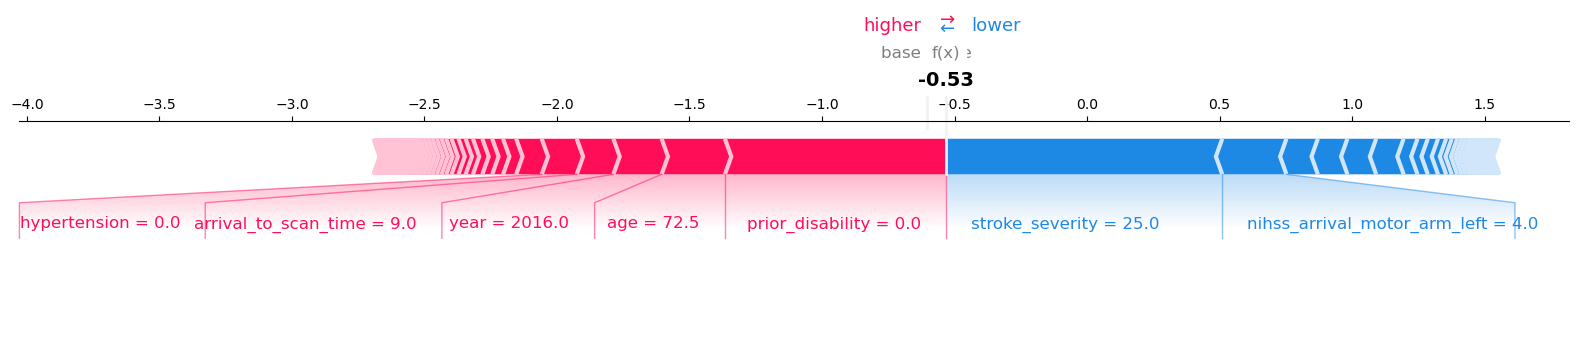

In [24]:
shap.plots.force(shap_values_extended.base_values[instance,c], 
                 shap_values=shap_values_kfold[k][instance,:,c], 
                 features=X_test.iloc[instance],
                 feature_names=feature_names_ohe, 
                 matplotlib=True)

Plot SHAP waterfall plot for the specified instance, kfold & class (shows the same information as the forceplot above)

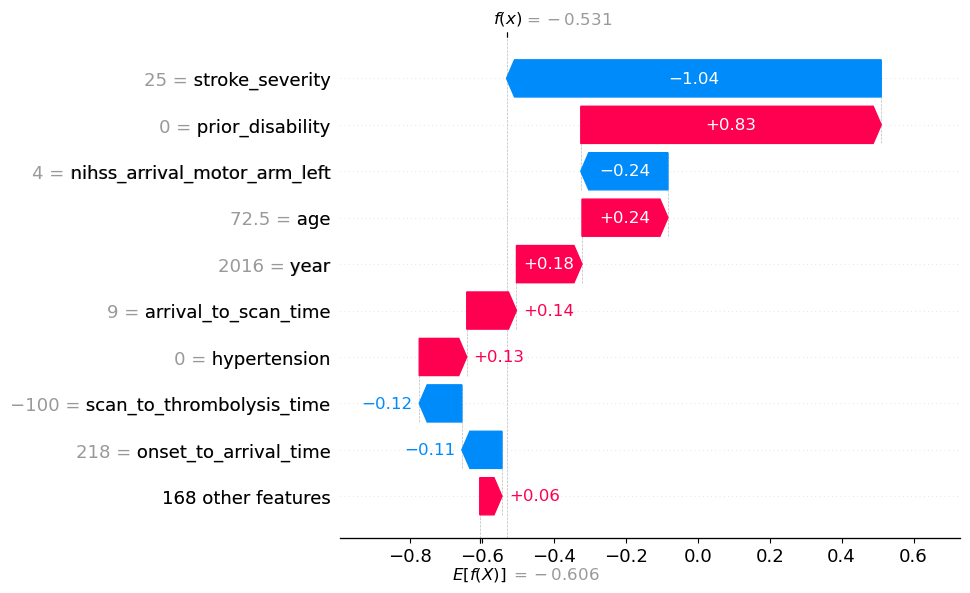

In [25]:
shap.waterfall_plot(shap.Explanation(values=shap_values_kfold[k][instance,:,c], 
                                     base_values=shap_values_extended.base_values[instance,c], 
                                     data=X_test.iloc[instance],  
                                     feature_names=X_test.columns.tolist()))

Let's view these plots for all of the outcome classes for a single instance.

Tried to create a function to create a set of force plots - subplots do not appear to be possible with force plots.
Instead create and show each individual force plot.

In [26]:
def create_forceplot_multiclass_grid(
                row, n_classes, k, y_data_row, shap_values_list_row,
                list_base_values, X_data_row, feature_names, pred_mrs_row):

    """
    Each figure showing the relationship between each combination of features 
    on the SHAP value.
    Subplots do not seem to be possible with force plots.

    Args:
        row [integer]: the instance
        n_classes [list]: Class names
        k [integer]: kfold
        y_data_row [string]: the observed class
        shap_values_list_row [list]: shap values
        list_base_values [list]: base values
        X_data_row [series]: feature values for instance
        feature_names [list]: feature names
        pred_mrs_row [string]: the predicted class

    Return:
        None
    """
    
    for c in range(n_classes):
        shap.plots.force(list_base_values[c],
                        shap_values=shap_values_list_row[c],
                        features=X_data_row,
                        feature_names=feature_names, 
                        matplotlib=True,
                        show=False)

        title = (f"Predicting discharge mRS {c}.\n\nForce plot for instance "
                 f"{row}, for k-fold {k} (observed discharge mRS: {y_data_row},"
                 f" predicted discharge mRS: {pred_mrs_row}.\n")

        plt.title(title, y=1.75, pad=-50)
        
        plt.gcf().set_size_inches(20,6)
        plt.tight_layout()
        plt.show()

    return()

View force plots for all classes for a single instance (for a single k-fold). The class with the highest probability, is the resulting classification for this instance from the model.

(Can not look at a specific instance across the kfolds, as an instance is only in the test set for one kfold).

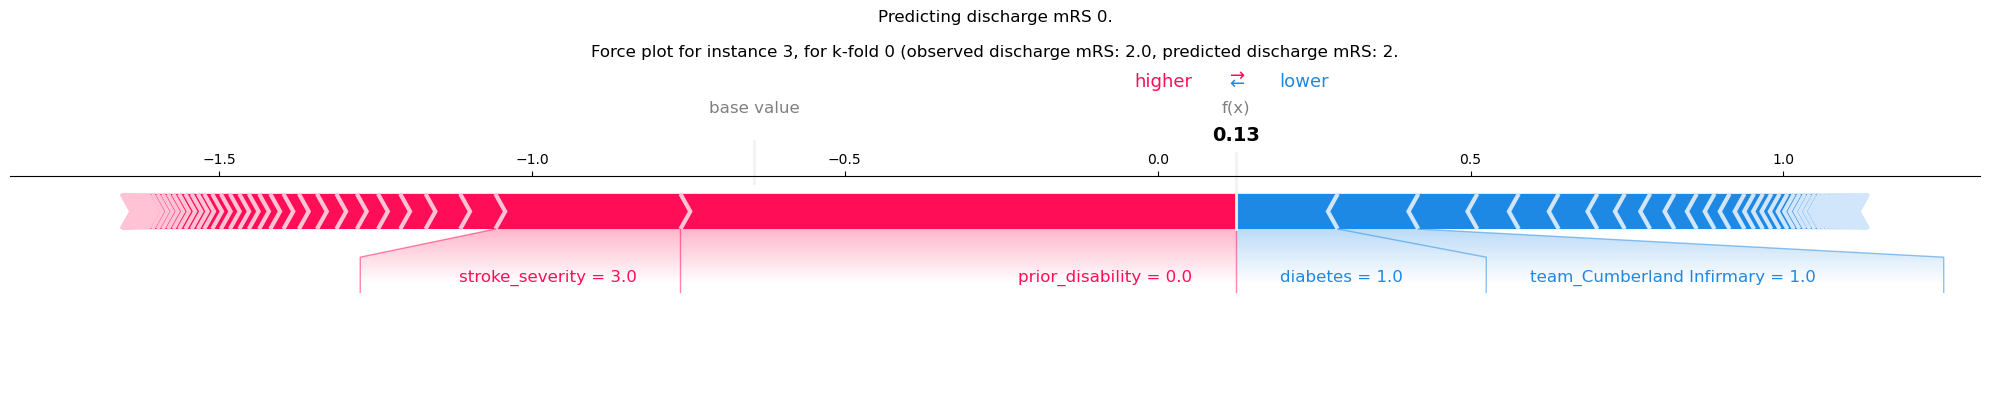

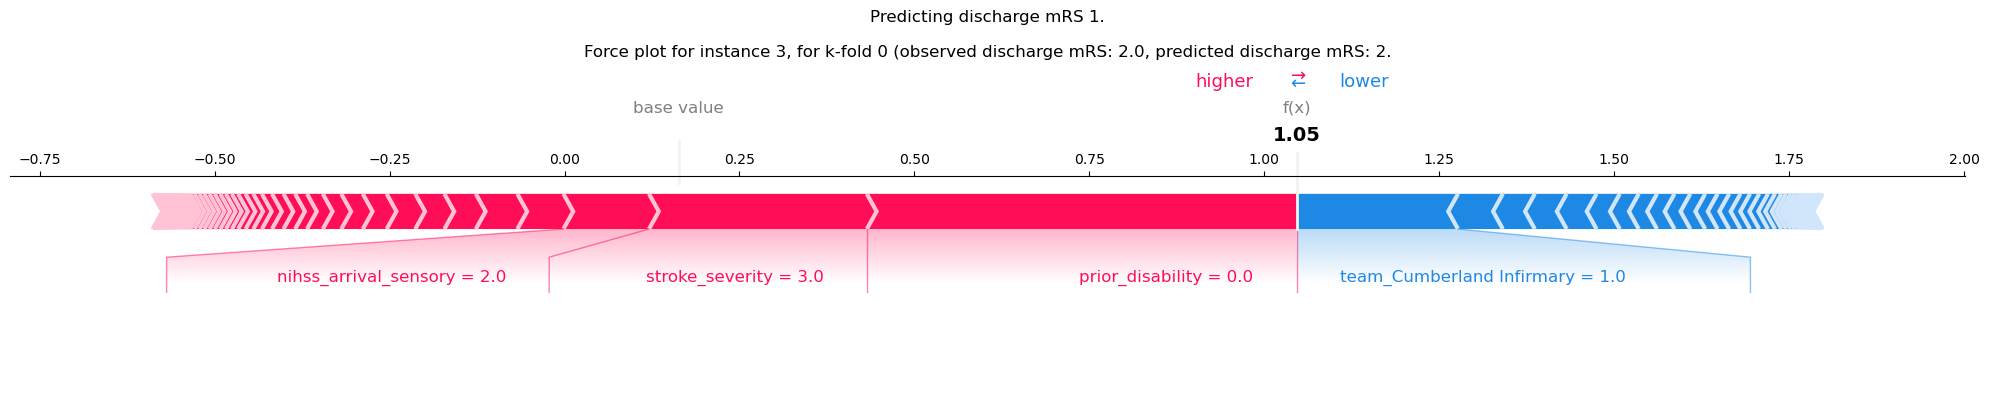

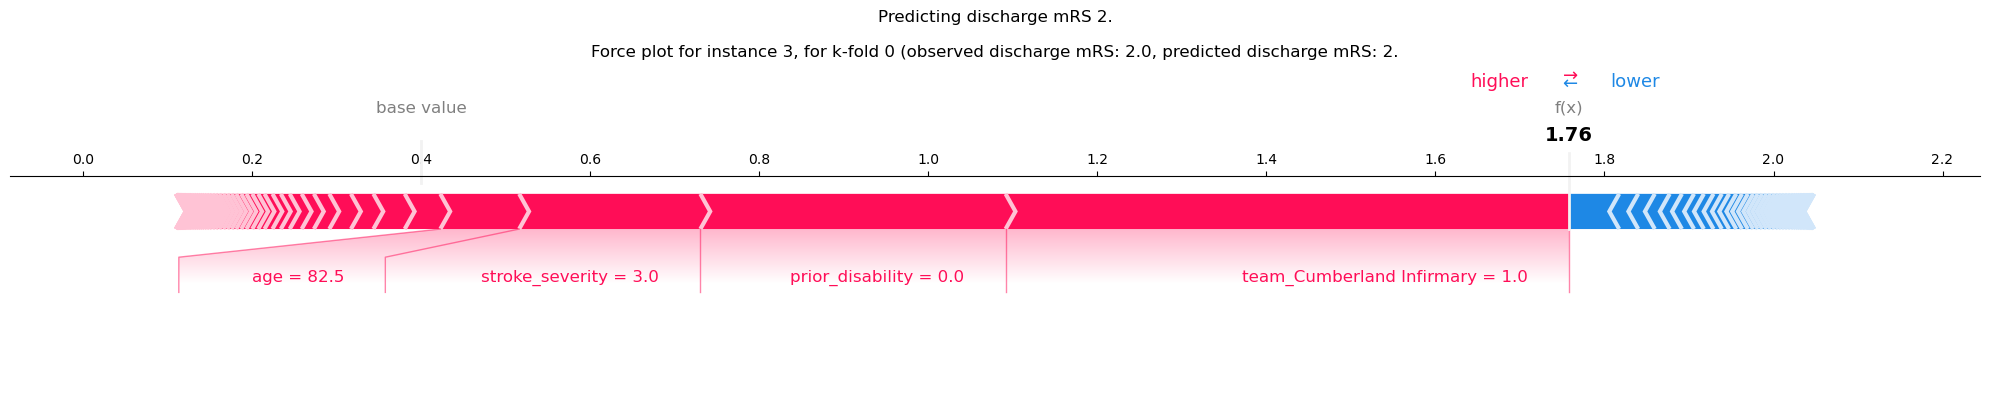

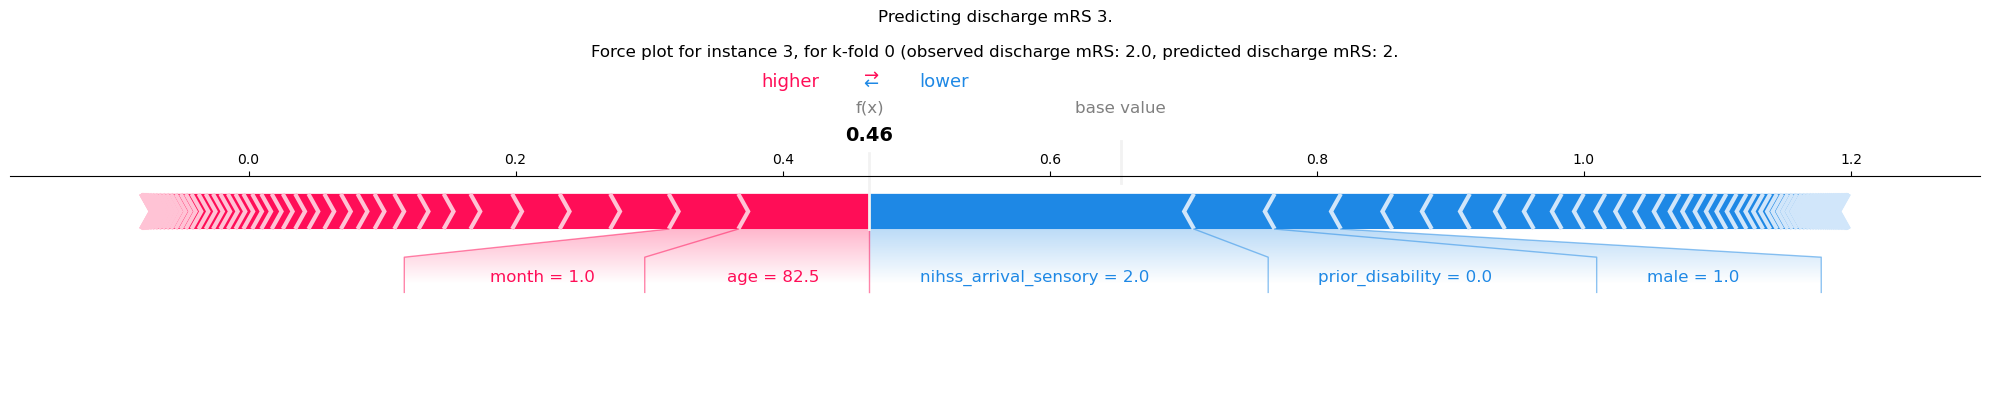

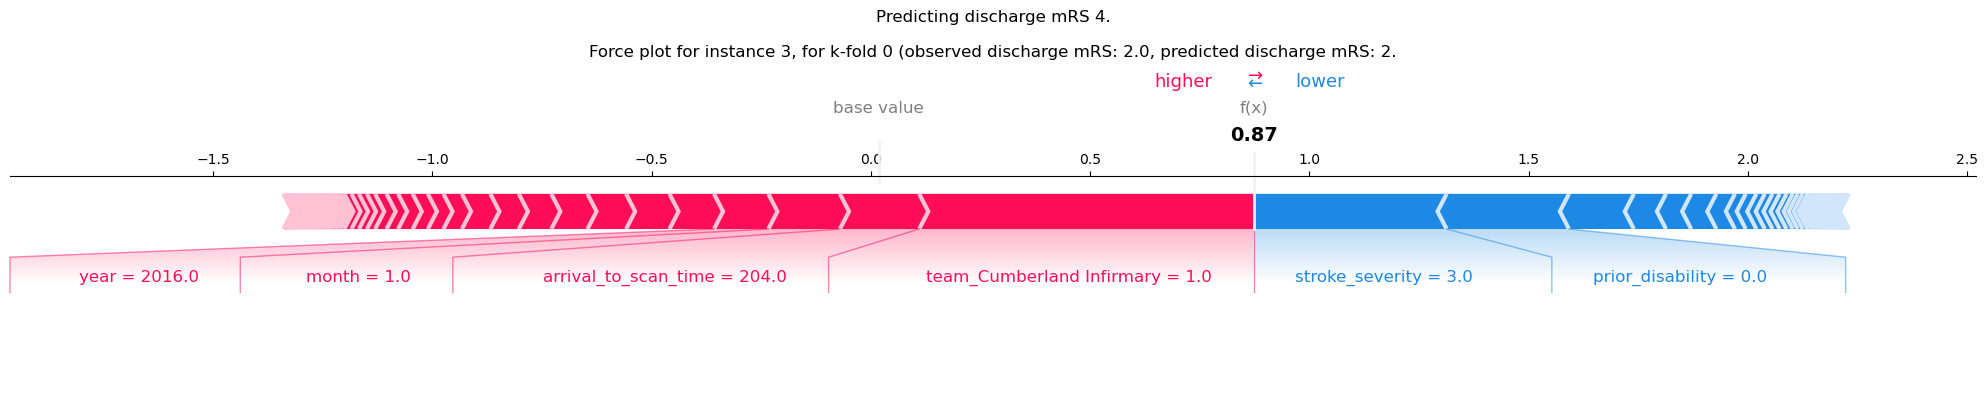

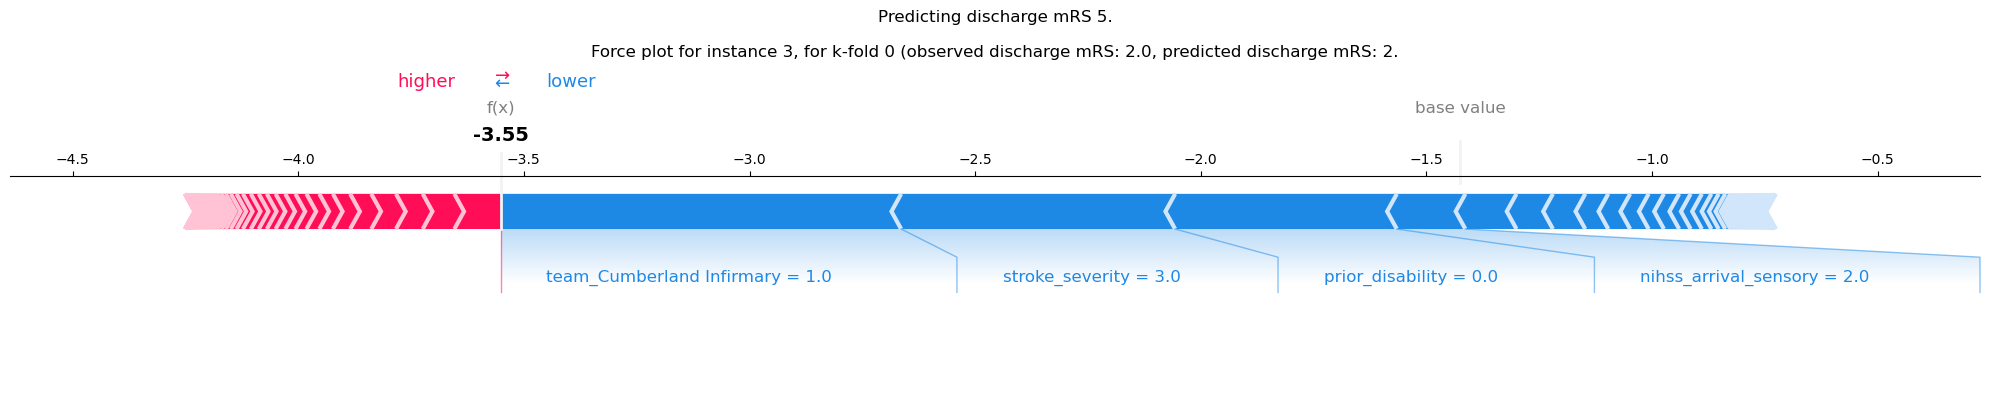

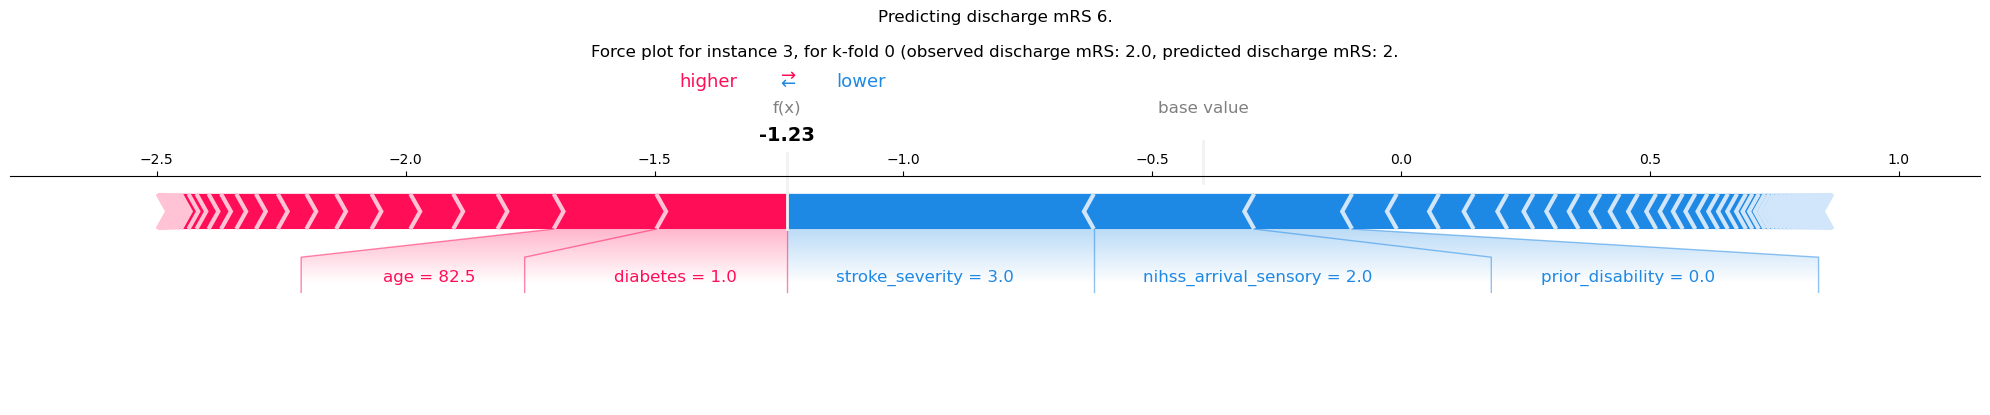

()

In [27]:
k = 0
# Initialise empty list
list_shap_values = []
list_base_values = []

# Putting the SHAP values in the required format
for c in range(n_classes):
    list_shap_values.append(shap_values_kfold[k][instance,:,c])
    list_base_values.append(shap_values_extended_kfold[k].base_values[instance,c])

y_pred = y_pred_kfold[k]
(X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                  test_data_kfold[k],
                                                  'discharge_disability')

# Call funciton to create subplots
create_forceplot_multiclass_grid(instance, n_classes, k,
                                 y_test.iloc[instance], 
                                 list_shap_values,
                                 list_base_values, 
                                 X_test.iloc[instance], 
                                 feature_names_ohe, y_pred[instance])


Function to create a set of waterfall plots

In [28]:
def create_waterfall_multiclass_grid(
                row, n_classes, k, y_data_row, shap_values_list_row,
                list_base_values, X_data_row, feature_names, pred_mrs_row):

    """
    Create a matrix of subplots per class. Each showing the relationship between
    each combination of features on the SHAP value.
    Setup matrix of subplots
    
    Args:
        row [integer]: the instance
        n_classes [list]: Class names
        k [integer]: kfold
        y_data_row [string]: the observed class
        shap_values_list_row [list]: shap values
        list_base_values [list]: base values
        X_data_row [series]: feature values for instance
        feature_names [list]: feature names
        pred_mrs_row [string]: the predicted class

    Return:
        None
    """
    fig = plt.figure()

    # Set overall title
    fig.suptitle(f'Waterfall for instance {row}.\n'
                 f'Observed discharge mRS: {y_data_row}, '
                 f'predicted discharge mRS: {pred_mrs_row}.\n'
                 f'(a subplot for each mRS class, for k-fold {k})',
                fontsize=20)

    for c in range(n_classes):
        ax = fig.add_subplot(4,2,c+1)
        shap.waterfall_plot(shap.Explanation(values=shap_values_list_row[c], 
                                            base_values=list_base_values[c], 
                                            data=X_data_row,  
                                            feature_names=feature_names), 
                                            show=False)
        ax.set_title(f"Predicting discharge mRS {c}")
        
    plt.gcf().set_size_inches(20,15)
    plt.tight_layout()
    plt.show()

    return()

View waterfall plots for all classes for a single instance (for a single k-fold). The class with the highest probability, is the resulting classification for this instance from the model.

(Can not look at a specific instance across the kfolds, as an instance is only in the test set for one kfold).

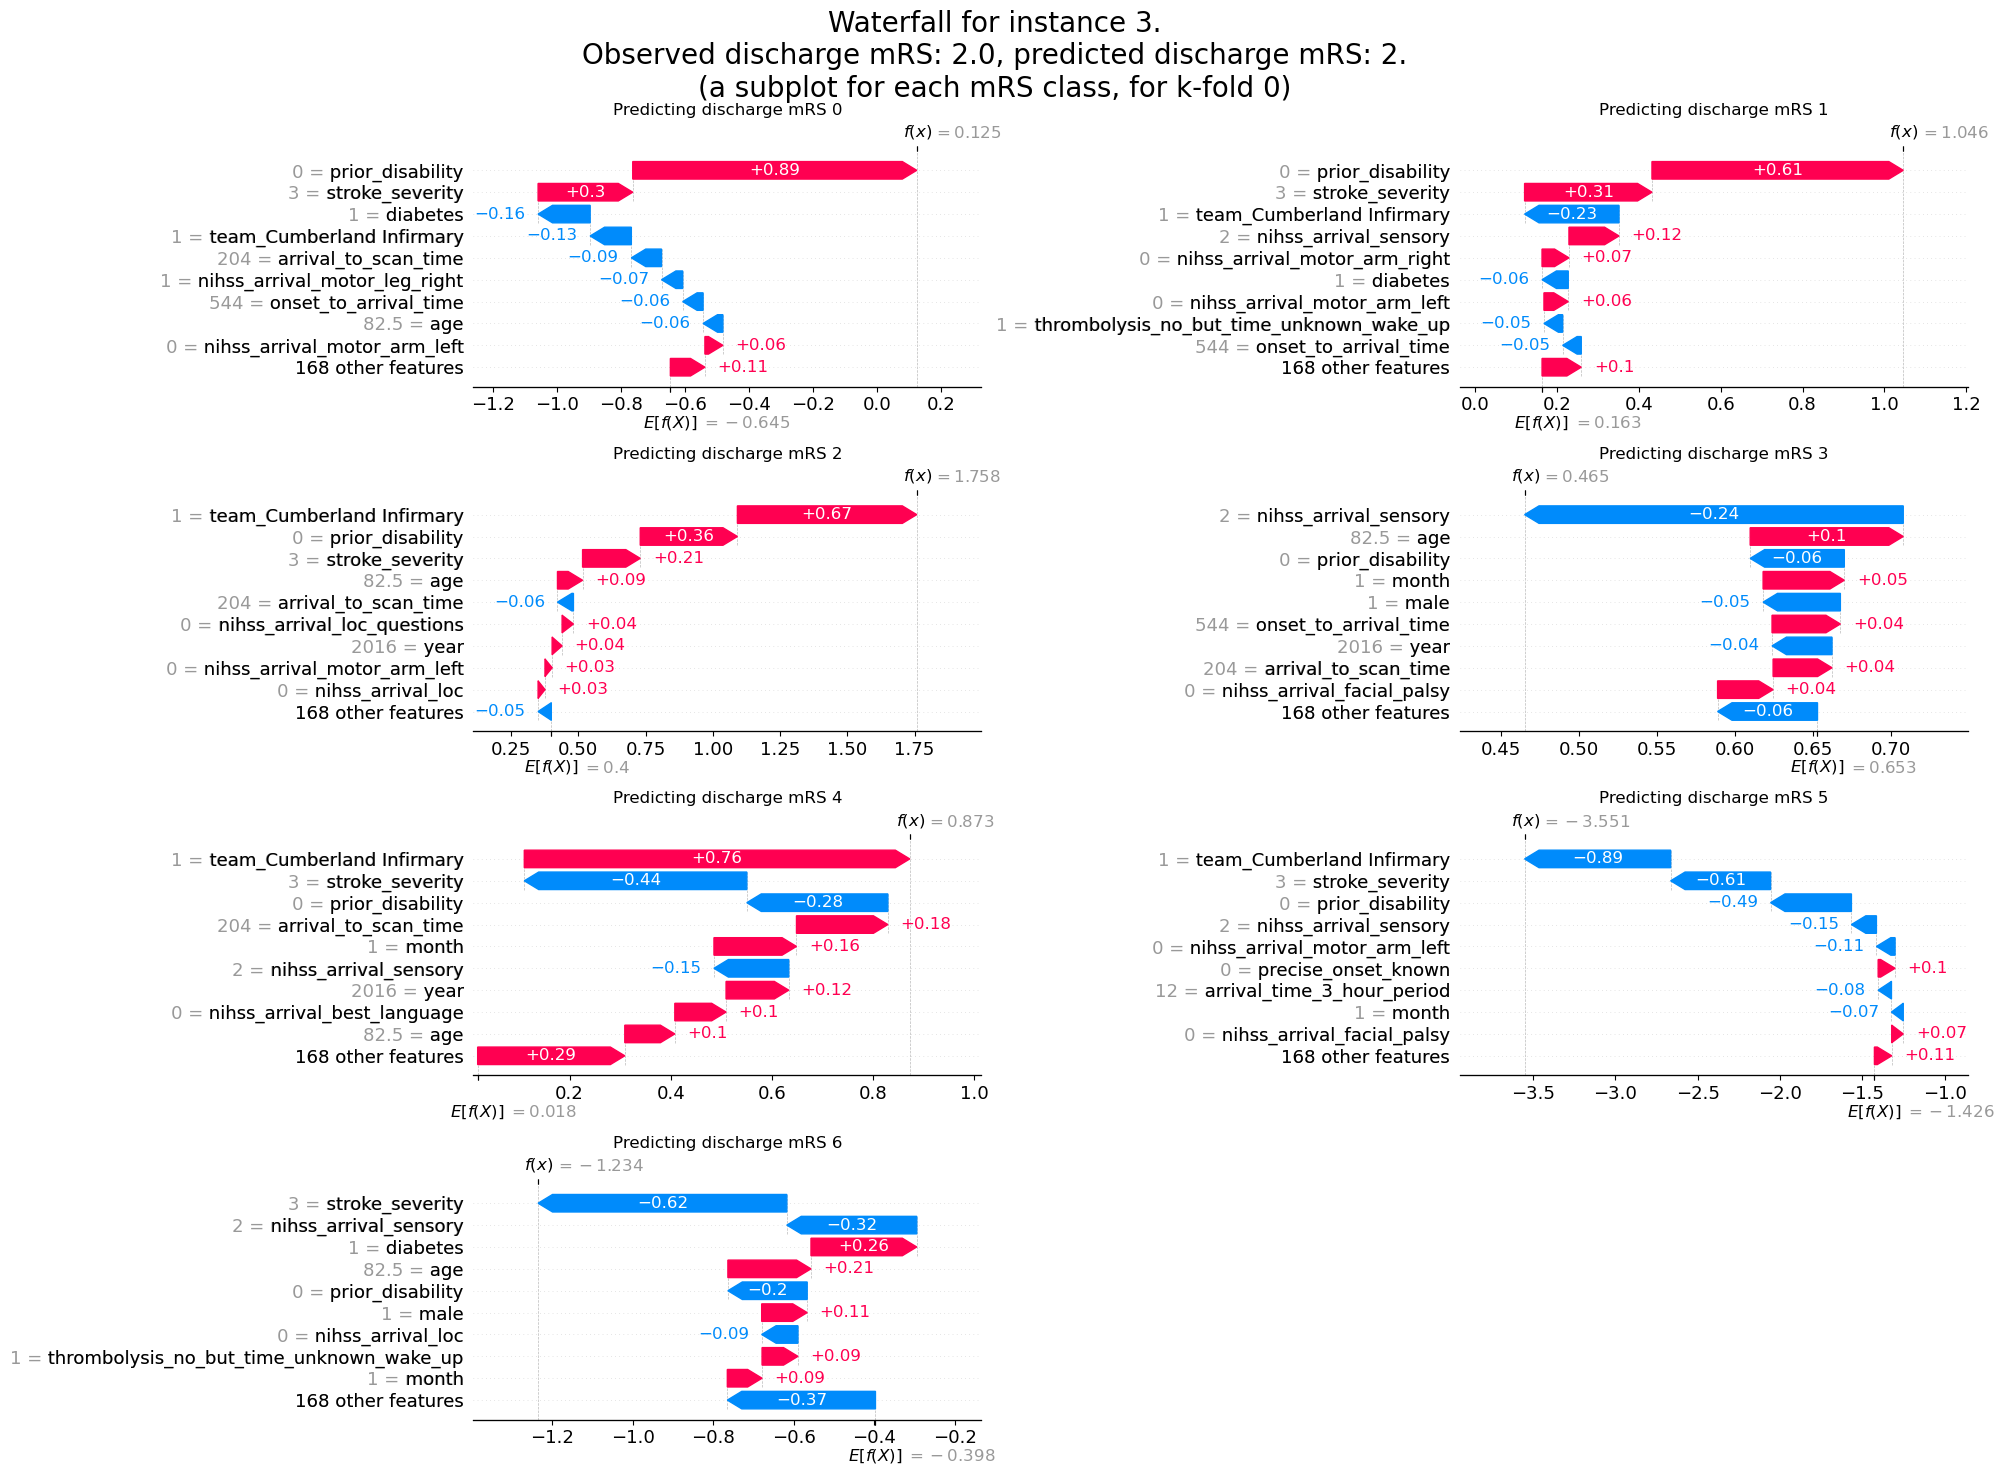

()

In [29]:
# Select kfold
k = 0

# Initialise empty list
list_shap_values = []
list_base_values = []

# Put the SHAP values in the required format
for c in range(n_classes):
    list_shap_values.append(shap_values_kfold[k][instance,:,c])
    list_base_values.append(shap_values_extended_kfold[k].base_values[instance,c])

# Get the prediction for this kfold
y_pred = y_pred_kfold[k]

# Get data for this kfold
(X_train, X_test, y_train, y_test) = get_x_y_data(train_data_kfold[k],
                                                  test_data_kfold[k],
                                                  'discharge_disability')

# Call function to create subplots
create_waterfall_multiclass_grid(instance, n_classes, k,
                                 y_test.iloc[instance], 
                                 list_shap_values,
                                 list_base_values, X_test.iloc[instance], 
                                 feature_names_ohe, y_pred[instance])

Duration to run notebook

In [30]:
str(datetime.timedelta(seconds=(time.time()-start_time)))

'0:00:06.198815'